# EDA for BigEarthNet Data

In this notebook, we will attempt to perform EDA to understand the distribution of the class labels in the training and validation data. We will also perform a visualization of the different vegetative and water canopy indices on the images. Some of these indices are taken from the Sentinel2 


In [55]:
IMG_BASE_PATH = '/home/cagastya/hdd/BigEarthNet-v1.0/'
CSV_DIR = 'data'

In [1]:
import sys
import os
import numpy as np
import PIL
import rasterio
from matplotlib import pyplot as plt
import cv2
import pandas as pd
%matplotlib inline
import time
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import box
from scipy.signal import find_peaks

## 1. Create RGB Bands for Visualization

Lets view the satellite images we download for each ground truth location from crop land and visualize them using their RGB information

In [67]:
# Spectral band names to read related GeoTIFF files
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B09',
              'B07', 'B08', 'B8A', 'B11', 'B12']

rgb_names = ['B04', 'B03', 'B02']
ag_names = ['B11', 'B12', 'B8A']
band_combinations = [rgb_names, ag_names]

SCALE_FACTOR = 5000

def plot_band_combs(foldername, base_paths, band_combinations, scale = SCALE_FACTOR):
  '''
  This function is used to visualize a set of images at a fixed latitude 
  and varying longitudes. he function can take multiple band combinations
  which will be plotted as separate rows.
  '''
  imarrays = []
  for comb in band_combinations:
    for base_path in base_paths:
      for b, band_name in enumerate(comb):
        #print(base_path)
        # First finds related GeoTIFF path and reads values as an array
        band_path = os.path.join(foldername, base_path, f'{base_path}_{band_name}.tif')
        band_ds = rasterio.open(band_path)
        raster_band = np.array(band_ds.read(1))
        band_data = np.array(raster_band)
        #print(band_data.shape)
        if b == 0:
            imarray = np.zeros((3404, 2784,3))
        if band_data.shape != imarray.shape[:2]:
            band_data = cv2.resize(band_data, (imarray.shape[1],imarray.shape[0]))
        imarray[:,:,b] = band_data / scale

      imarrays.append(imarray)

  fix, axes = plt.subplots(ncols=len(base_paths),
                            nrows=len(band_combinations),
                            sharex=True,
                            sharey=True,
                            figsize=(4*len(base_paths),6*len(band_combinations)))
  axes = axes.flatten()
  for i, img in enumerate(imarrays):
    axes[i].imshow(img)
  for ax in axes:
    ax.set_axis_off()
        
  plt.subplots_adjust(hspace=0.0,wspace=0.0)

## 2. Labels

First let us look at the labels we have in the dataset.

In [3]:
# Load the labels json file
import json
labels = pd.read_json('label_indices.json')
labels

,original_labels
Agro-forestry areas,21
Airports,5
Annual crops associated with permanent crops,18
Bare rock,30
"Beaches, dunes, sands",29
Broad-leaved forest,22
Burnt areas,32
Coastal lagoons,40
Complex cultivation patterns,19
Coniferous forest,23


In [4]:
labels = labels['original_labels']
labels.head()

Agro-forestry areas                             21
Airports                                         5
Annual crops associated with permanent crops    18
Bare rock                                       30
Beaches, dunes, sands                           29
Name: original_labels, dtype: int64

In [5]:
print(f'Total number of labels: {len(labels)}')

Total number of labels: 43


## 3. Data

Let us look at the label distribution of the data.

### 3.1 Distribution of labels

In [18]:
# Load the training data counts
def addCount (d1, d2):
    return {k : d1.get(k, 0) + d2.get(k, 0) for k in (set(d1) | set(d2))}

# Load the training data counts
with open('train_counts.json', 'r') as fp:
    train = json.load(fp)
    
with open('val_counts.json', 'r') as fp:
    val = json.load(fp)
    
with open('test_counts.json', 'r') as fp:
    test = json.load(fp)
    
tc = addCount(train, val)
tc = addCount(tc, test)
    
tc
cnt_dt = pd.DataFrame(list(tc.items()), columns= ['label','count']).sort_values('count', ascending = False)
cnt_dt

,label,count
36,Non-irrigated arable land,278778
23,Mixed forest,268497
34,Coniferous forest,251344
12,Transitional woodland/shrub,226543
17,Broad-leaved forest,214711
31,"Land principally occupied by agriculture, with...",197897
5,Complex cultivation patterns,157737
19,Pastures,149978
22,Sea and ocean,110330
28,Discontinuous urban fabric,100092


In [19]:
total = 0
for val in tc.values():
    total += val
print(f'Total number of Images: {total}')
print(f'Number of different labels seen data: {len(tc)}')

Total number of Images: 2345055
Number of different labels seen data: 43


In [25]:
cnt1 = !cat data/train_labels.csv | wc -l
cnt2 = !cat data/test_labels.csv | wc -l
cnt3 = !cat data/val_labels.csv | wc -l
cnt = int(cnt1[0]) + int(cnt2[0]) + int(cnt3[0])
cnt

519284

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 <a list of 43 Text xticklabel objects>)

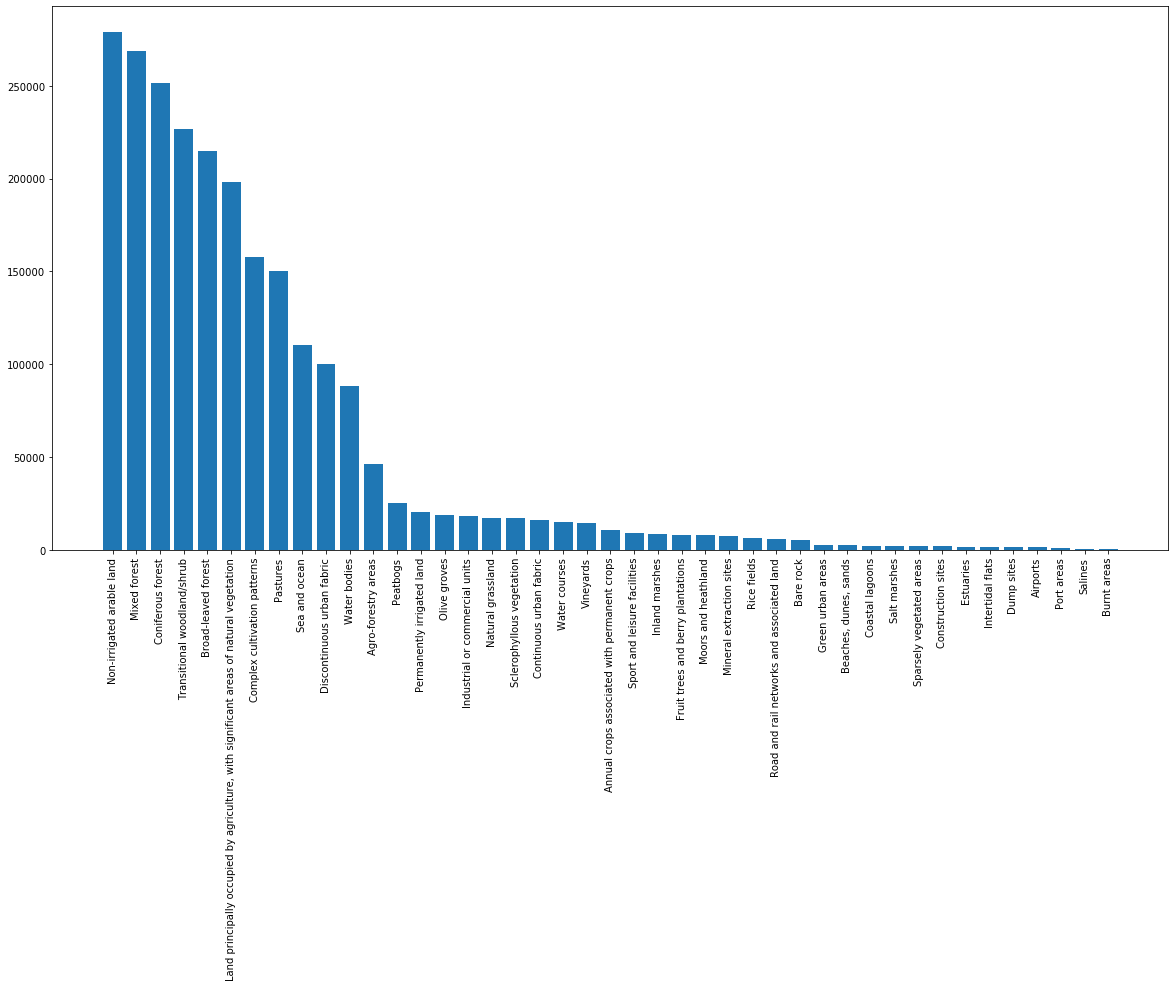

In [34]:
plt.figure(figsize=(20,10))
plt.bar(cnt_dt['label'], cnt_dt['count'])
plt.xticks(rotation='vertical')

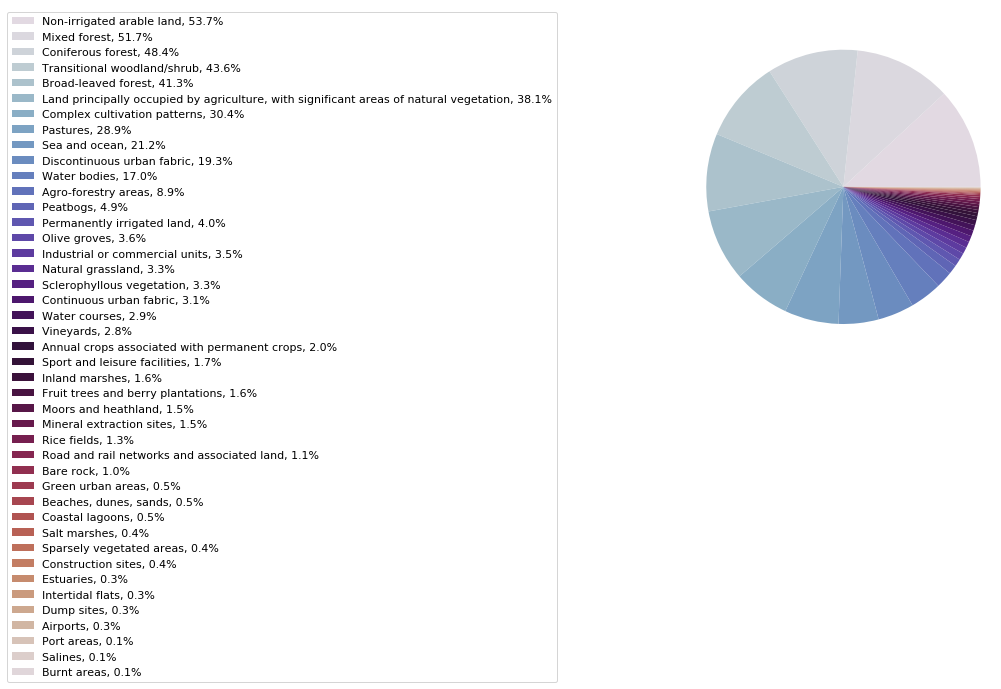

In [36]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#sizes = [15, 30, 45, 10]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

theme = plt.get_cmap('twilight')
ax1.set_prop_cycle("color", [theme(1. * i / len(cnt_dt['count'])) for i in range(len(cnt_dt['count']))])
ax1.pie(cnt_dt['count'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

total = cnt #sum(cnt_dt['count'])
plt.legend(
    loc='upper right',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(cnt_dt['label'], cnt_dt['count'])],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

### 3.2. Single Vs Multi Class Patches

Based on the output above, we can see that even though there are only 269695 actual patch images in the training directory, we see a total of 806960 image labels. This is because BigEarthNet is a multilabel data where there are many instances where an image has been assigned more than 1 labels. We can also see that the training data includes all the labels. Now lets see of these images, how many belong to a single class vs multiclass

In [10]:
train_data = pd.read_csv('data/train_labels.csv', delimiter = ';', header = None)
train_data.columns = ['patch', 'label']
train_data.head()

,patch,label
0,S2A_MSIL2A_20170717T113321_28_87,['Pastures']
1,S2A_MSIL2A_20170717T113321_28_90,['Pastures']
2,S2A_MSIL2A_20170717T113321_29_83,['Pastures']
3,S2A_MSIL2A_20170717T113321_29_84,['Pastures']
4,S2A_MSIL2A_20170717T113321_29_85,['Pastures']


In [11]:
import ast
# See how many of these include a multi-class label
train_data['Length'] = train_data.label.apply(lambda x: len(ast.literal_eval(x)))
train_data.head(10)


,patch,label,Length
0,S2A_MSIL2A_20170717T113321_28_87,['Pastures'],1
1,S2A_MSIL2A_20170717T113321_28_90,['Pastures'],1
2,S2A_MSIL2A_20170717T113321_29_83,['Pastures'],1
3,S2A_MSIL2A_20170717T113321_29_84,['Pastures'],1
4,S2A_MSIL2A_20170717T113321_29_85,['Pastures'],1
5,S2A_MSIL2A_20170717T113321_29_87,"['Pastures', 'Land principally occupied by agr...",2
6,S2A_MSIL2A_20170717T113321_29_88,['Pastures'],1
7,S2A_MSIL2A_20170717T113321_29_89,"['Pastures', 'Land principally occupied by agr...",2
8,S2A_MSIL2A_20170717T113321_29_90,"['Pastures', 'Land principally occupied by agr...",2
9,S2A_MSIL2A_20170717T113321_30_80,['Pastures'],1


In [12]:
single_class = train_data[train_data['Length'] == 1].shape[0]
multi_class = train_data[train_data['Length'] > 1].shape[0]
print(f'Number of patches belonging to a single class: {single_class}')
print(f'Number of patches belonging to multiple class: {multi_class}')
print(f'Total Sum: {single_class + multi_class}')

Number of patches belonging to a single class: 52456
Number of patches belonging to multiple class: 217239
Total Sum: 269695


In [13]:
# Check how many of these strictly belong to just permanent irrigated land
PATTERN = 'Permanently irrigated land'
pil_s = train_data[train_data['Length'] == 1 & train_data['label'].str.contains(PATTERN)]
print(f'Patches that only belong to Permanently Irrigated Land label: {pil_s.shape[0]}')

# Check how many belong to the multi class
pil_m = train_data[(train_data['label'].str.contains(PATTERN)) & (train_data['Length'] > 1 )]
print(f'Patches that belong to Permanently Irrigated Land label for mlti class: {pil_m.shape[0]}')

# Check in all how many belong to permanently irrigated land
total = train_data[train_data['label'].str.contains(PATTERN)].shape[0]
print(f'Total images belonging to permanently irrigated land label: {total}')

Patches that only belong to Permanently Irrigated Land label: 99
Patches that belong to Permanently Irrigated Land label for mlti class: 6867
Total images belonging to permanently irrigated land label: 6966


In [14]:
print(f'Pecentage of data belonging to irrigated land: {(total/269695) * 100}')

Pecentage of data belonging to irrigated land: 2.5829177404104637


### 1. Irrigated Data

In [69]:
base_paths = pil_s['patch'].head(4)
base_paths = base_paths.tolist()
base_paths

['S2A_MSIL2A_20171002T112111_48_6',
 'S2B_MSIL2A_20180224T112109_48_6',
 'S2A_MSIL2A_20170813T112121_48_6',
 'S2A_MSIL2A_20171002T112112_15_33']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


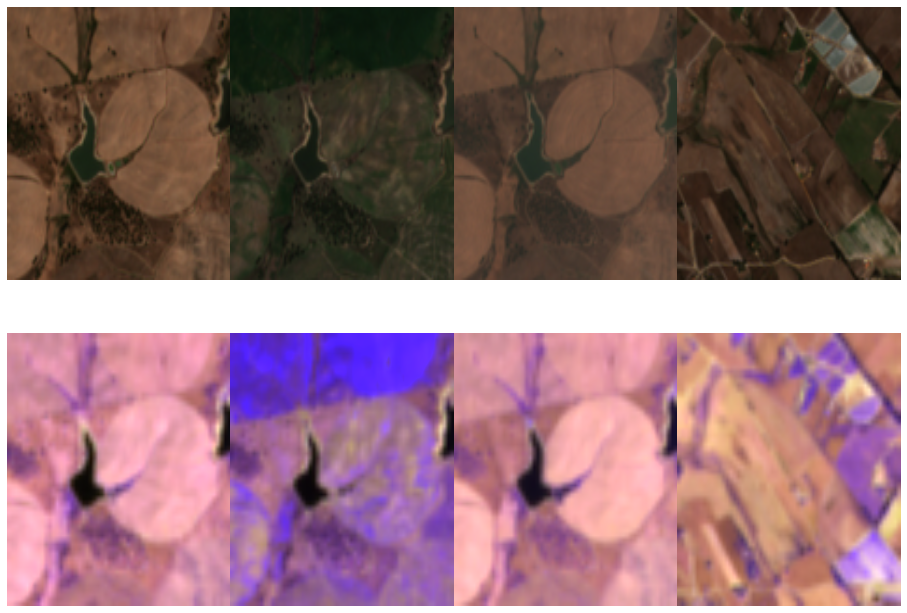

In [70]:
# Call the plot function
plot_band_combs(IMG_BASE_PATH, base_paths, band_combinations)

### 2. Not Irrigated

['S2A_MSIL2A_20170717T113321_28_87', 'S2A_MSIL2A_20170717T113321_28_90', 'S2A_MSIL2A_20170717T113321_29_83', 'S2A_MSIL2A_20170717T113321_29_84']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


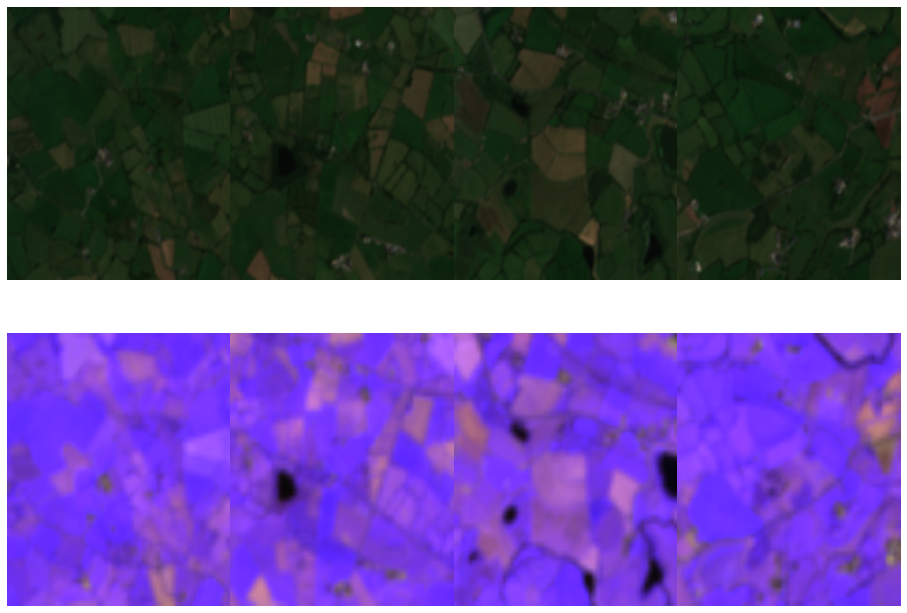

In [94]:
base_paths = train_data[(train_data['label'].str.contains(PATTERN)) == False].head(4)
base_paths = base_paths['patch'].tolist()
print(base_paths)

# Call the plot function (these appear to be pastures)
plot_band_combs(IMG_BASE_PATH, base_paths, band_combinations)

## Vegetative Indices

We are interested in seeing the enhanced vegetative index (EVI), soil adjusted vegetative index (SAVI), Moisture stress index (MSI) etc. of these locations

$EVI = 2.5(NIR - Red)/(NIR + 6 * Red - 7.5 * Blue + 1)$

$SAVI = (1 + L)(NIR - Red)/(NIR + Red + L)$ where L = 0.5 (canopy background adjustment factor)

- Moisture Stress Index: This index is a reflectance measurement that is sensitive to increasing leaf water content. As the water content of leaves in vegetation canopies increases, the strength of the absorption around 1599 nm increases. Absorption at 819 nm is nearly unaffected by changing water content, so it is used as the reference. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, and studies of ecosystem physiology. The MSI is inverted relative to the other water VIs; higher values indicate greater water stress and less water content. 

$MSI = MidIR/ NIR$ or here we use SWIR (band 11)/NIR (band 8)

- Normalized Difference Infrared Index: This index is a reflectance measurement that is sensitive to changes in water content of plant canopies. The NDII uses a normalized difference formulation instead of a simple ratio, and the index values increase with increasing water content. Applications include crop agricultural management, forest canopy monitoring, and vegetation stress detection.

$NDII = (NIR - MIR)/ (NIR + MIR)$

- Normalized Multi-band Drought Index (NMDI): This index takes into account a soil moisture background to monitor potential drought conditions. Three specific bands were chosen because of their unique response to variations in soil and vegetation moisture. The index uses the difference between two liquid-water absorption bands in the shortwave-infrared region (1640 and 2130 nm) as a measure of water sensitivity in vegetation and soil. This index is also commonly used in forest-fire detection.

As soil moisture increases, the index values decrease. Index values range from 0.7 to 1 for dry soil, 0.6 to 0.7 for soil with intermediate moisture, and less than 0.6 for wet soil.

$NMDI = (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))$

- Water Band Index (WBI): This index is a reflectance measurement that is sensitive to changes in canopy water status. As the water content of vegetation canopies increases, the strength of the absorption around 970 nm increases relative to that of 900 nm. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, cropland management, and studies of ecosystem physiology.

$WBI = Band-9 / Band-8A $


In [90]:
import matplotlib as mpl

def get_band_data(band_path):
  band_ds = rasterio.open(band_path)
  raster_band = np.array(band_ds.read(1))
  return np.array(raster_band)

def plot_vegetative_moisture_index(folderpath, base_paths, index, scale = SCALE_FACTOR):
    imarrays = []
    nrows, ncols = np.shape(base_paths)
    
    assert(index in 'EVI SAVI NDII NMDI'.split())
    
    if index == 'EVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            # First finds related GeoTIFF path and reads values as an array
            nir_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B08.tif'))
            red_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B04.tif'))
            blue_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B02.tif'))

            # Since the blue band is only added to decrease noise this variant of EVI called EVI2 
            # serves as a good proxy indicator for EVI 
            # -- dual band EVI2
            imarray = 2.5 * ((nir_data - red_data) / (nir_data + (2.4 * red_data) + 1))
            imarrays.append(imarray)
    elif index == 'SAVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            red_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B04.tif'))
                        
            imarray = 1.5*(nir_data-red_data) / (nir_data + red_data + 0.5)
            imarrays.append(imarray)
    elif index == 'NMDI':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            sw1_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B11.tif'))
            sw2_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B12.tif'))
            # --- Normalized Difference Infrared Index
            imarray = (nir_data - (sw1_data - sw2_data))/ (nir_data + (sw1_data + sw2_data))
            imarrays.append(imarray)
    elif index == 'NDII':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            mir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B11.tif'))
            # --- Normalized Difference Infrared Index
            imarray = (nir_data - mir_data)/ (nir_data + mir_data)
            imarrays.append(imarray)

    fix, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             sharex=True,
                             sharey=True,
                             figsize=(4*ncols,6*nrows))
    axes = axes.flatten()
    for i, img in enumerate(imarrays):
        im = axes[i].imshow(img, cmap=color_map)

    for ax in axes:
        ax.set_axis_off()

    # Colorbar
    fix.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, pad = 0.05)
        
    plt.subplots_adjust(hspace=0.1,wspace=0.1)
    ret = [np.nanmedian(x) for x in imarrays]
    print(ret)
    return ret
    
    

### 1. Irrigated Data

[0.2826409499447312, 1.143991781858289, 0.3281632668732967, 0.43446942841751146]
[0.2671560134676313, 0.883800406421639, 0.30656436319239694, 0.3951029452669067]


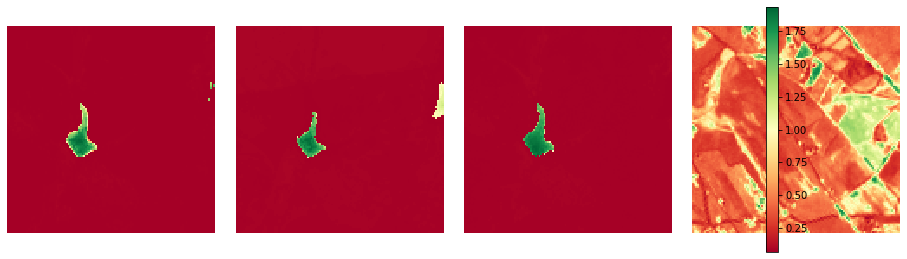

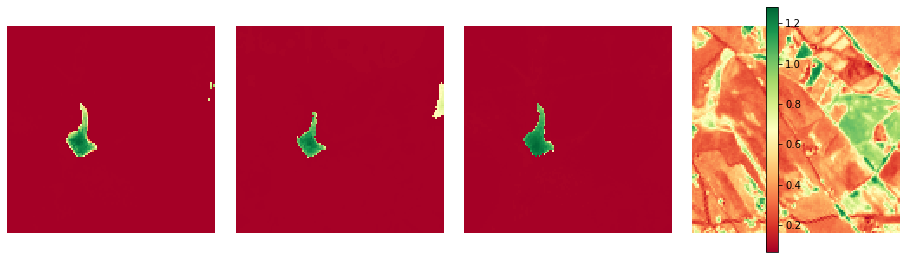

In [93]:
base_paths = [['S2A_MSIL2A_20171002T112111_48_6',
 'S2B_MSIL2A_20180224T112109_48_6',
 'S2A_MSIL2A_20170813T112121_48_6',
 'S2A_MSIL2A_20171002T112112_15_33']]

evi2 = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'EVI')
savi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'SAVI')
#msi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'NDII')
#nmdi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'NMDI')

      EVI  SAVI  NDII  NMDI
EVI   1.0   1.0  -1.0  -1.0
SAVI  1.0   1.0  -1.0  -1.0
NDII -1.0  -1.0   1.0   1.0
NMDI -1.0  -1.0   1.0   1.0


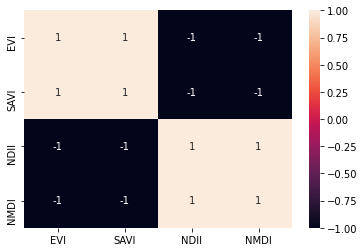

In [27]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'NDII': msi,
        'NMDI' : nmdi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','NDII', 'NMDI'])
df.head()
corrMatrix = df.corr()
print (corrMatrix)
sn.heatmap(corrMatrix, annot=True)
plt.show()


### 2. Not Irrigated data

[1.854486814646177, 1.7977094190120555, 1.7544778205399734, 1.876581046864387]
[1.2450907546969536, 1.219736621507415, 1.200065114074256, 1.2548136698785122]


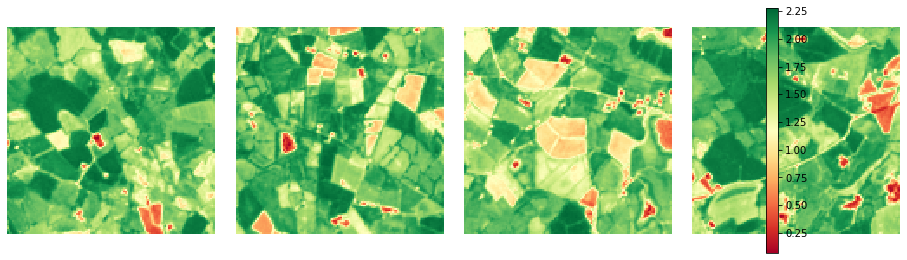

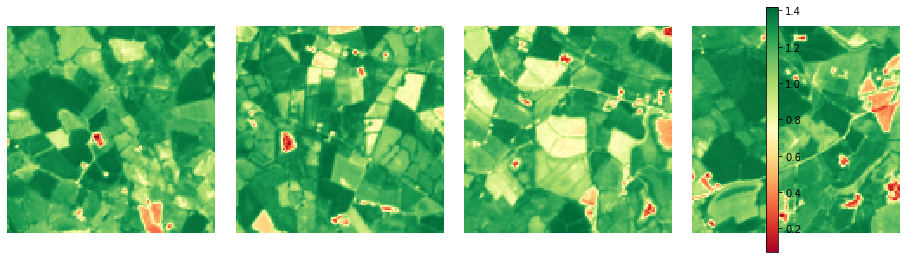

In [96]:
base_paths = [['S2A_MSIL2A_20170717T113321_28_87', 'S2A_MSIL2A_20170717T113321_28_90', 
               'S2A_MSIL2A_20170717T113321_29_83', 'S2A_MSIL2A_20170717T113321_29_84']]
evi2 = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'EVI')
savi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'SAVI')
#msi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'NDII')
#nmdi = plot_vegetative_moisture_index(os.path.join(BASE_PATH, RF_DATA_DIR), base_paths, 'NMDI')

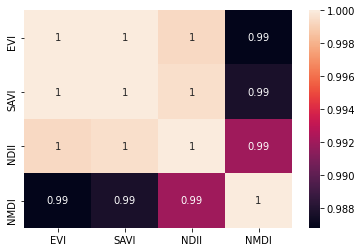

In [33]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'NDII': msi,
        'NMDI' : nmdi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','NDII', 'NMDI'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()